In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with correct separator
file_path = "/home/maria/CrimeStats/data/avalik_1(1).csv"
dat = pd.read_csv(file_path, sep='\t', encoding='utf-8')

# Filter for Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

# Parse date and time
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

# Combine to datetime
tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])

# Clean and split crime types
tallinn['SyndmusLiik'] = (
    tallinn['SyndmusLiik']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Split by comma and explode to new rows
tallinn_expanded = tallinn.assign(
    SyndmusLiik=tallinn['SyndmusLiik'].str.split(',')
).explode('SyndmusLiik')

# Remove whitespace and invalid empty entries
tallinn_expanded['SyndmusLiik'] = tallinn_expanded['SyndmusLiik'].str.strip()
tallinn_expanded = tallinn_expanded[tallinn_expanded['SyndmusLiik'] != '']

# Set datetime index
tallinn_expanded.set_index('ToimDatetime', inplace=True)

# Group by day and crime type
daily_crime_matrix = (
    tallinn_expanded
    .groupby([pd.Grouper(freq='D'), 'SyndmusLiik'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
daily_crime_matrix.shape
daily_crime_matrix

SyndmusLiik,AVALIKU_KORRA_RIKKUMINE,ILLEGAALNE_KAUBA_MUUK,JALGRATTA_MOPEEDI_VARGUS,JUHTUM_LOOMAGA,JUHTUM_TULIRELVAGA,KADUNUD_ESE/DOKUMENT,KAUPLEMISE_NOUETE_RIKKUMINE,KEHALINE_VAARKOHTLEMINE,KELMUS,KONFLIKT/OMAVOLI,...,MUU,NARKOJUHTUM,PISIVARGUS,PLAHVATUS,POMMIAHVARDUS_KAHTLUS,ROOVIMINE,TULEKAHJU,VALIMISED,VANDALISM,VARGUS
ToimDatetime,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,4,8
2024-01-02,1,0,0,0,0,0,0,1,0,0,...,0,0,6,0,0,0,0,0,0,6
2024-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,5
2024-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,4
2024-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-15,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
2025-05-16,0,0,0,0,0,0,0,0,0,0,...,1,0,3,0,0,0,0,0,0,3
2025-05-18,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1


In [13]:
import numpy as np
np.where(daily_crime_matrix>1)
daily_crime_matrix.shape
np.array(daily_crime_matrix)[0,18]

np.int64(2)

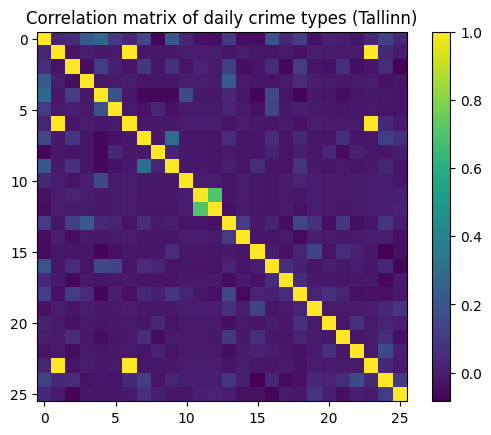

In [2]:
from sklearn.preprocessing import StandardScaler

X = daily_crime_matrix.values
Xz = StandardScaler().fit_transform(X)
import matplotlib.pyplot as plt
import numpy as np

corr = np.corrcoef(Xz, rowvar=False)

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.title("Correlation matrix of daily crime types (Tallinn)")
plt.show()


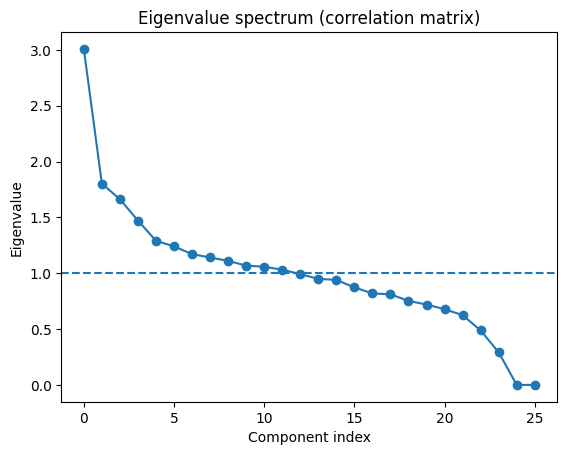

In [3]:
eigvals = np.linalg.eigvalsh(corr)
eigvals = eigvals[::-1]  # descending

plt.figure()
plt.plot(eigvals, marker='o')
plt.axhline(1.0, linestyle='--')  # Kaiser criterion
plt.title("Eigenvalue spectrum (correlation matrix)")
plt.xlabel("Component index")
plt.ylabel("Eigenvalue")
plt.show()


In [4]:
from sklearn.decomposition import FactorAnalysis

max_k = 10
loglikes = []

for k in range(1, max_k + 1):
    fa = FactorAnalysis(n_components=k, random_state=0)
    fa.fit(Xz)
    loglikes.append(fa.score(Xz))


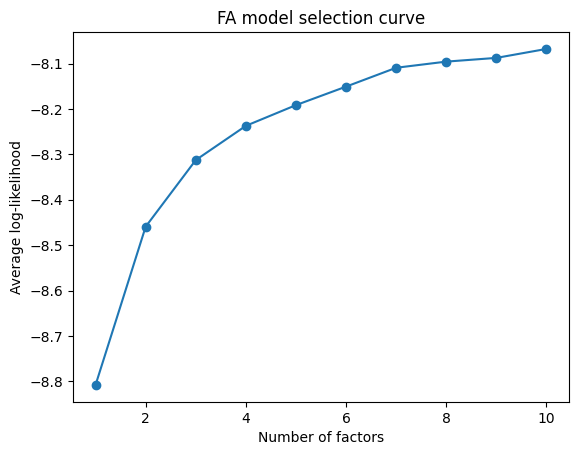

In [5]:
plt.figure()
plt.plot(range(1, max_k + 1), loglikes, marker='o')
plt.xlabel("Number of factors")
plt.ylabel("Average log-likelihood")
plt.title("FA model selection curve")
plt.show()


In [8]:
k = 3
k=10
fa = FactorAnalysis(n_components=k, random_state=0)
Z = fa.fit_transform(Xz)
Lambda = fa.components_.T  # shape: (crime_types, factors)


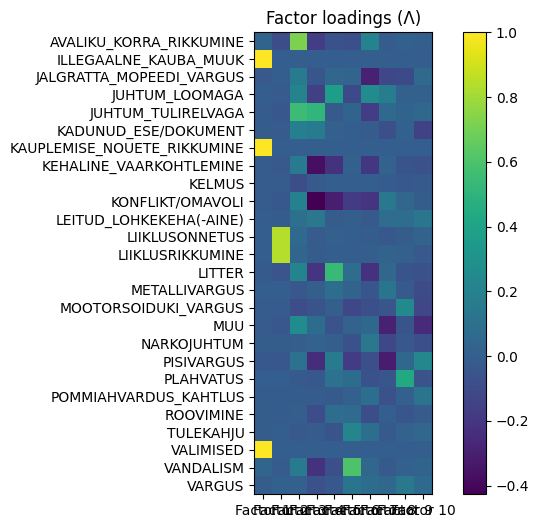

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(Lambda)
plt.colorbar()
plt.yticks(range(len(daily_crime_matrix.columns)),
           daily_crime_matrix.columns)
plt.xticks(range(k), [f"Factor {i+1}" for i in range(k)])
plt.title("Factor loadings (Λ)")
plt.show()


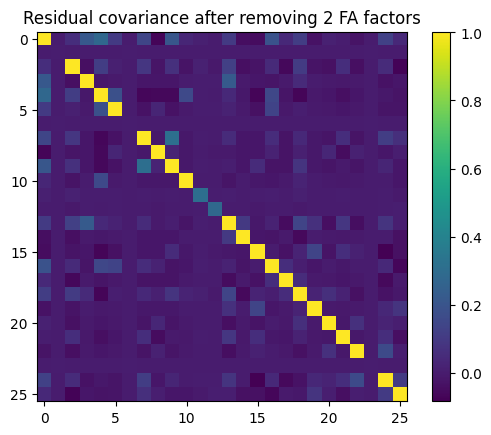

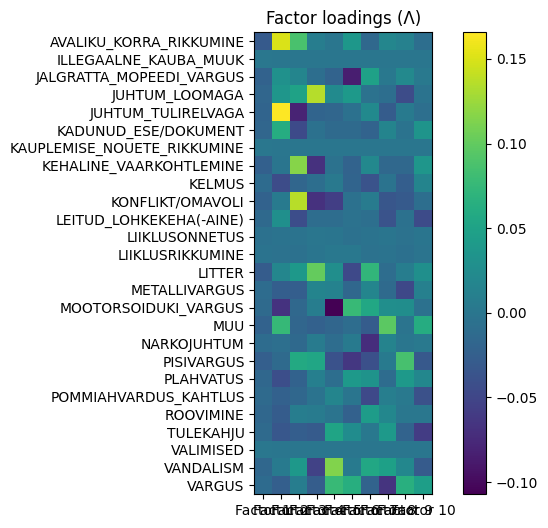

In [13]:
from sklearn.decomposition import FactorAnalysis
import numpy as np

k = 2
fa2 = FactorAnalysis(n_components=k, random_state=0)
fa2.fit(Xz)

Lambda2 = fa2.components_.T        # (p × 2)
Psi2 = np.diag(fa2.noise_variance_)

Sigma_emp = np.cov(Xz, rowvar=False)

Sigma_res = Sigma_emp - Lambda2 @ Lambda2.T

plt.figure()
plt.imshow(Sigma_res)
plt.colorbar()
plt.title("Residual covariance after removing 2 FA factors")
plt.show()

fa_res = FactorAnalysis(n_components=10, random_state=0)
fa_res.fit(Sigma_res)

Lambda_res = fa_res.components_.T
k=10
plt.figure(figsize=(8, 6))
plt.imshow(Lambda_res)
plt.colorbar()
plt.yticks(range(len(daily_crime_matrix.columns)),
           daily_crime_matrix.columns)
plt.xticks(range(k), [f"Factor {i+1}" for i in range(k)])
plt.title("Factor loadings (Λ)")
plt.show()



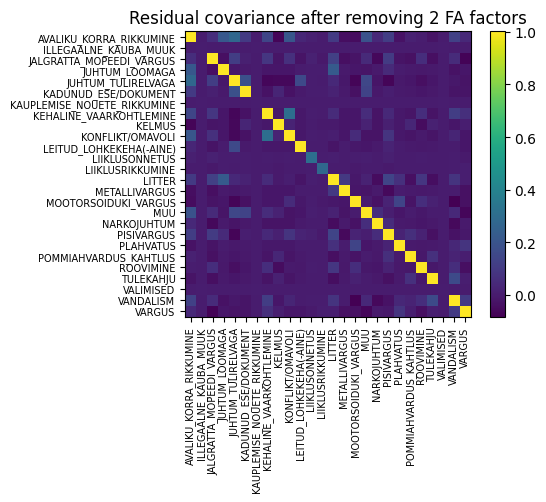

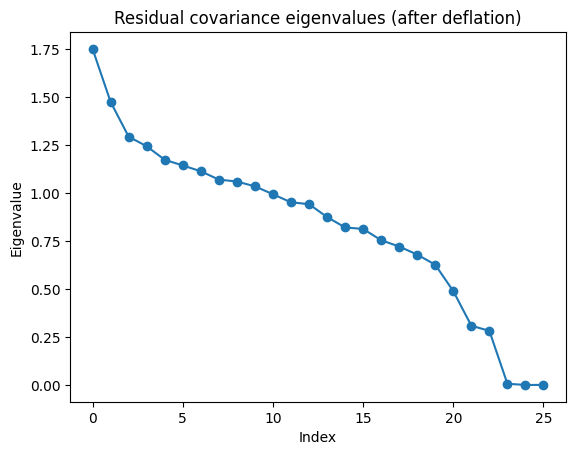

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis

# Xz: standardized daily_crime_matrix (n_days × p_types)
# If you haven't made it yet:
# from sklearn.preprocessing import StandardScaler
# Xz = StandardScaler().fit_transform(daily_crime_matrix.values)

p = Xz.shape[1]

# 1) Fit FA with k trusted factors (try k=2)
k = 2
fa = FactorAnalysis(n_components=k, random_state=0)
fa.fit(Xz)

Lambda = fa.components_.T                  # (p × k)
Psi = np.diag(fa.noise_variance_)          # (p × p)

# 2) Empirical covariance (on standardized data)
Sigma_emp = np.cov(Xz, rowvar=False)       # (p × p)

# 3) Residual covariance after stripping shared low-rank structure
Sigma_res = Sigma_emp - (Lambda @ Lambda.T)

# 4) Plot residual covariance (or residual correlation-like view)
plt.figure(figsize=(6, 5))
plt.imshow(Sigma_res)
plt.colorbar()
plt.title(f"Residual covariance after removing {k} FA factors")
plt.xticks(range(p), daily_crime_matrix.columns, rotation=90, fontsize=7)
plt.yticks(range(p), daily_crime_matrix.columns, fontsize=7)
plt.tight_layout()
plt.show()

# Optional: eigen-spectrum of residual (tells if leftover ensures more factors)
eigvals_res = np.linalg.eigvalsh((Sigma_res + Sigma_res.T) / 2)[::-1]
plt.figure()
plt.plot(eigvals_res, marker='o')
plt.title("Residual covariance eigenvalues (after deflation)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()


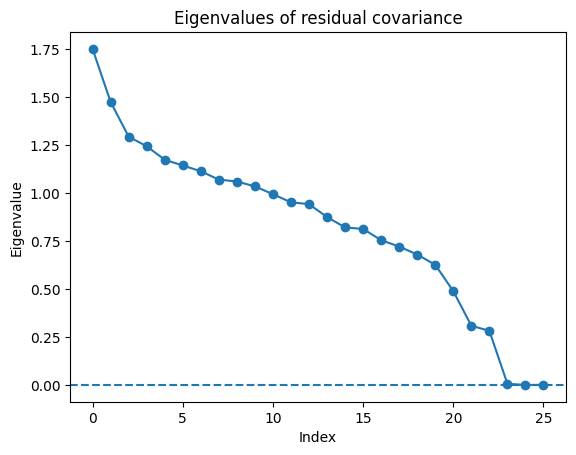

In [15]:
eigvals_res = np.linalg.eigvalsh((Sigma_res + Sigma_res.T) / 2)[::-1]

plt.figure()
plt.plot(eigvals_res, marker='o')
plt.axhline(0, linestyle='--')
plt.title("Eigenvalues of residual covariance")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.show()


In [16]:
# Project out the first k factors from the data
Z = fa2.transform(Xz)                 # latent factors (n × k)
X_hat = Z @ Lambda2.T                 # reconstructed shared signal
X_res = Xz - X_hat                    # residual data

# Now FA on residual DATA (this is valid)
fa_res = FactorAnalysis(n_components=3, random_state=0)
fa_res.fit(X_res)

Lambda_res = fa_res.components_.T
